In [4]:
#| default_exp workflow

In [ ]:
#| export

from chewc.structs import *
from chewc.pheno import *
from chewc.select import *
from chewc.cross import *
import jax
import jax.numpy as jnp
from jax import lax
from functools import partial
from typing import Tuple

print("This document represents a template for a simple breeding simulation for selection. It is meant to be a guide to developing my complex or flexible breeding designs.")


@partial(jax.jit, static_argnames=("n_select", "n_offspring", "max_crossovers"))
def selection_step(
    carry: BreedingState,
    _, # Placeholder for lax.scan's iteration number
    trait: Trait,
    genetic_map: GeneticMap,
    heritabilities: jnp.ndarray,
    n_select: int,
    n_offspring: int,
    max_crossovers: int
) -> Tuple[BreedingState, jnp.ndarray]:
    """
    Executes one full cycle of selection and breeding.
    This function is designed to be the body of a lax.scan loop.
    """
    key, pheno_key, mating_key, cross_key = jax.random.split(carry.key, 4)
    current_pop = carry.population

    # 1. Evaluate the population
    phenotypes, tbvs = calculate_phenotypes(
        key=pheno_key, population=current_pop, trait=trait, heritability=heritabilities
    )
    mean_tbv = jnp.mean(tbvs[:, 0]) # Track genetic gain for trait 1

    # 2. Select top parents
    selected_parents = select_top_k(current_pop, phenotypes[:, 0], k=n_select)

    # 3. Generate a random mating plan
    pairings = random_mating(mating_key, n_parents=n_select, n_crosses=n_offspring)
    mother_indices, father_indices = pairings[:, 0], pairings[:, 1]

    # 4. Create the next generation
    mothers_geno = selected_parents.geno[mother_indices]
    fathers_geno = selected_parents.geno[father_indices]
    mothers_ibd = selected_parents.ibd[mother_indices]
    fathers_ibd = selected_parents.ibd[father_indices]

    # Vectorize the crossing operation over all pairs
    vmapped_cross = jax.vmap(
        cross_pair, in_axes=(0, 0, 0, 0, 0, None, None)
    )
    offspring_keys = jax.random.split(cross_key, n_offspring)
    offspring_geno, offspring_ibd = vmapped_cross(
        offspring_keys, mothers_geno, fathers_geno, mothers_ibd, fathers_ibd, genetic_map, max_crossovers
    )

    # 5. Form the new population and update the state
    new_generation = carry.generation + 1
    new_ids = jnp.arange(n_offspring, dtype=jnp.int32) + carry.next_id
    new_meta = jnp.stack(
        [
            new_ids,
            selected_parents.meta[mother_indices, 0],
            selected_parents.meta[father_indices, 0],
            jnp.full((n_offspring,), new_generation, dtype=jnp.int32),
        ],
        axis=-1,
    )
    new_population = Population(geno=offspring_geno, ibd=offspring_ibd, meta=new_meta)

    next_state = BreedingState(
        population=new_population,
        key=key,
        generation=new_generation,
        next_id=carry.next_id + n_offspring
    )

    # The scan function requires a `(carry, output)` return signature.
    # `carry` is the state for the next iteration.
    # `output` is the data we want to collect at each step.
    return next_state, mean_tbv


def run_simulation_cycles(
    initial_state: BreedingState,
    trait: Trait,
    genetic_map: GeneticMap,
    heritabilities: jnp.ndarray,
    n_cycles: int,
    n_select: int,
    n_offspring: int,
    max_crossovers: int
):
    """
    Runs the entire multi-cycle simulation using lax.scan for maximum performance.
    """
    # `lax.scan` requires the body function to be a callable that takes
    # (carry, x) and returns (new_carry, y). We use a lambda to fix the
    # static arguments and data that doesn't change over the loop.
    scan_fn = lambda carry, _: selection_step(
        carry,
        _,
        trait=trait,
        genetic_map=genetic_map,
        heritabilities=heritabilities,
        n_select=n_select,
        n_offspring=n_offspring,
        max_crossovers=max_crossovers
    )

    # Run the scan. The `None` is a placeholder for the `xs` array,
    # as we only care about the number of iterations (`length`).
    final_state, tbv_history = lax.scan(
        scan_fn, initial_state, None, length=n_cycles
    )

    return final_state, tbv_history


# ----------------------------------------------------
# Main execution script
# ----------------------------------------------------

if __name__ == "__main__":
    print("--- Running 10-Cycle Phenotypic Selection Experiment ---")

    # --- Simulation Parameters ---
    N_FOUNDERS = 5
    N_SELECT = 5
    N_OFFSPRING = 200 # Population size is kept constant after the first cycle
    N_CYCLES = 20

    N_CHR, N_LOCI = 5, 1000
    MAX_CROSSOVERS = 10
    SEED = 42

    key = jax.random.PRNGKey(SEED)

    # --- Setup ---
    key, pop_key, trait_key = jax.random.split(key, 3)
    print("\nStep 1: Initializing founder population...")
    founder_pop, genetic_map = quick_haplo(
        key=pop_key, n_ind=N_FOUNDERS, n_chr=N_CHR, seg_sites=N_LOCI,
        inbred=False, chr_length=1.0
    )

    print("Step 2: Initializing trait architecture...")
    trait_architecture = add_trait(
        key=trait_key, founder_pop=founder_pop, n_qtl_per_chr=50,
        mean=jnp.array([0.0]), var=jnp.array([1.0]),
        sigma=jnp.array([[10.0]])
    )
    heritabilities = jnp.array([0.9])

    # --- Initial State ---
    initial_state = BreedingState(
        population=founder_pop,
        key=key,
        generation=0,
        next_id=N_FOUNDERS # Next available individual ID
    )
    print(f"  - Founder population size: {N_FOUNDERS}")
    print(f"  - Selection: Top {N_SELECT} individuals")
    print(f"  - Offspring per cycle: {N_OFFSPRING}")

    # --- Burn-in Cycle ---
    print("\nStep 3: Running burn-in cycle to stabilize population size...")
    
    # Calculate initial TBV for generation 0
    key, initial_pheno_key = jax.random.split(initial_state.key)
    _, initial_tbvs = calculate_phenotypes(
        key=initial_pheno_key, population=initial_state.population,
        trait=trait_architecture, heritability=heritabilities
    )
    initial_mean_tbv = jnp.mean(initial_tbvs[:, 0])

    # Run the first selection step manually
    burn_in_state, first_cycle_tbv = selection_step(
        carry=initial_state,
        _ = 0, # Placeholder for iteration number
        trait=trait_architecture,
        genetic_map=genetic_map,
        heritabilities=heritabilities,
        n_select=N_SELECT,
        n_offspring=N_OFFSPRING,
        max_crossovers=MAX_CROSSOVERS,
    )

    # --- Run Simulation ---
    print(f"\nStep 4: Running remaining {N_CYCLES - 1} selection cycles (JIT compiling...)\n")
    
    # Run the rest of the simulation using lax.scan
    final_state, tbv_history = run_simulation_cycles(
        initial_state=burn_in_state,
        trait=trait_architecture,
        genetic_map=genetic_map,
        heritabilities=heritabilities,
        n_cycles=N_CYCLES - 1,
        n_select=N_SELECT,
        n_offspring=N_OFFSPRING,
        max_crossovers=MAX_CROSSOVERS,
    )

    # --- Report Results ---
    print("--- Results ---")
    print(f"Generation 00 Mean TBV: {initial_mean_tbv:.3f}")
    print(f"Generation 01 Mean TBV: {first_cycle_tbv:.3f} (Gain: {first_cycle_tbv - initial_mean_tbv:+.3f})")

    # Combine initial TBV, burn-in TBV, and the history from the scan
    full_history = jnp.concatenate([jnp.array([initial_mean_tbv, first_cycle_tbv]), tbv_history])
    for i, tbv in enumerate(tbv_history, 2):
        gain = tbv - full_history[i-1]
        print(f"Generation {i:02d} Mean TBV: {tbv:.3f} (Gain: {gain:+.3f})")

    total_gain = tbv_history[-1] - initial_mean_tbv
    print(f"\n--- Total Genetic Gain over {N_CYCLES} generations: {total_gain:+.3f} ---")


import matplotlib.pyplot as plt
plt.scatter(range(len(full_history)),full_history)

This document represents a template for a simple breeding simulation for selection. It is meant to be a guide to developing my complex or flexible breeding designs.
--- Running 10-Cycle Phenotypic Selection Experiment ---

Step 1: Initializing founder population...
Step 2: Initializing trait architecture...
  - Founder population size: 5
  - Selection: Top 5 individuals
  - Offspring per cycle: 200

Step 3: Running burn-in cycle to stabilize population size...

Step 4: Running remaining 19 selection cycles (JIT compiling...)

--- Results ---
Generation 00 Mean TBV: 0.000
Generation 01 Mean TBV: 0.000 (Gain: +0.000)
Generation 02 Mean TBV: -0.174 (Gain: -0.174)
Generation 03 Mean TBV: 2.769 (Gain: +2.943)
Generation 04 Mean TBV: 5.972 (Gain: +3.203)
Generation 05 Mean TBV: 9.831 (Gain: +3.859)
Generation 06 Mean TBV: 11.747 (Gain: +1.916)
Generation 07 Mean TBV: 13.027 (Gain: +1.280)
Generation 08 Mean TBV: 14.457 (Gain: +1.430)
Generation 09 Mean TBV: 15.276 (Gain: +0.819)
Generation 1


=== Summary by heritability (final TBV and total gain) ===

-- h2=0.30 --
    Pop=200 (sel=10)  |  Final TBV:  14.4354  |  Total Gain:  14.4354
    Pop=400 (sel=10)  |  Final TBV:  14.3819  |  Total Gain:  14.3819
    Pop=100 (sel=10)  |  Final TBV:  12.9180  |  Total Gain:  12.9180
     Pop=50 (sel=10)  |  Final TBV:  12.1482  |  Total Gain:  12.1482

-- h2=0.50 --
    Pop=400 (sel=10)  |  Final TBV:  14.5290  |  Total Gain:  14.5290
    Pop=200 (sel=10)  |  Final TBV:  14.2571  |  Total Gain:  14.2571
    Pop=100 (sel=10)  |  Final TBV:  13.0277  |  Total Gain:  13.0277
     Pop=50 (sel=10)  |  Final TBV:  12.2087  |  Total Gain:  12.2087

-- h2=0.70 --
    Pop=200 (sel=10)  |  Final TBV:  14.8146  |  Total Gain:  14.8146
    Pop=400 (sel=10)  |  Final TBV:  14.6057  |  Total Gain:  14.6057
    Pop=100 (sel=10)  |  Final TBV:  14.2565  |  Total Gain:  14.2565
     Pop=50 (sel=10)  |  Final TBV:  12.1662  |  Total Gain:  12.1662

-- h2=0.90 --
    Pop=200 (sel=10)  |  Final TBV:  14.

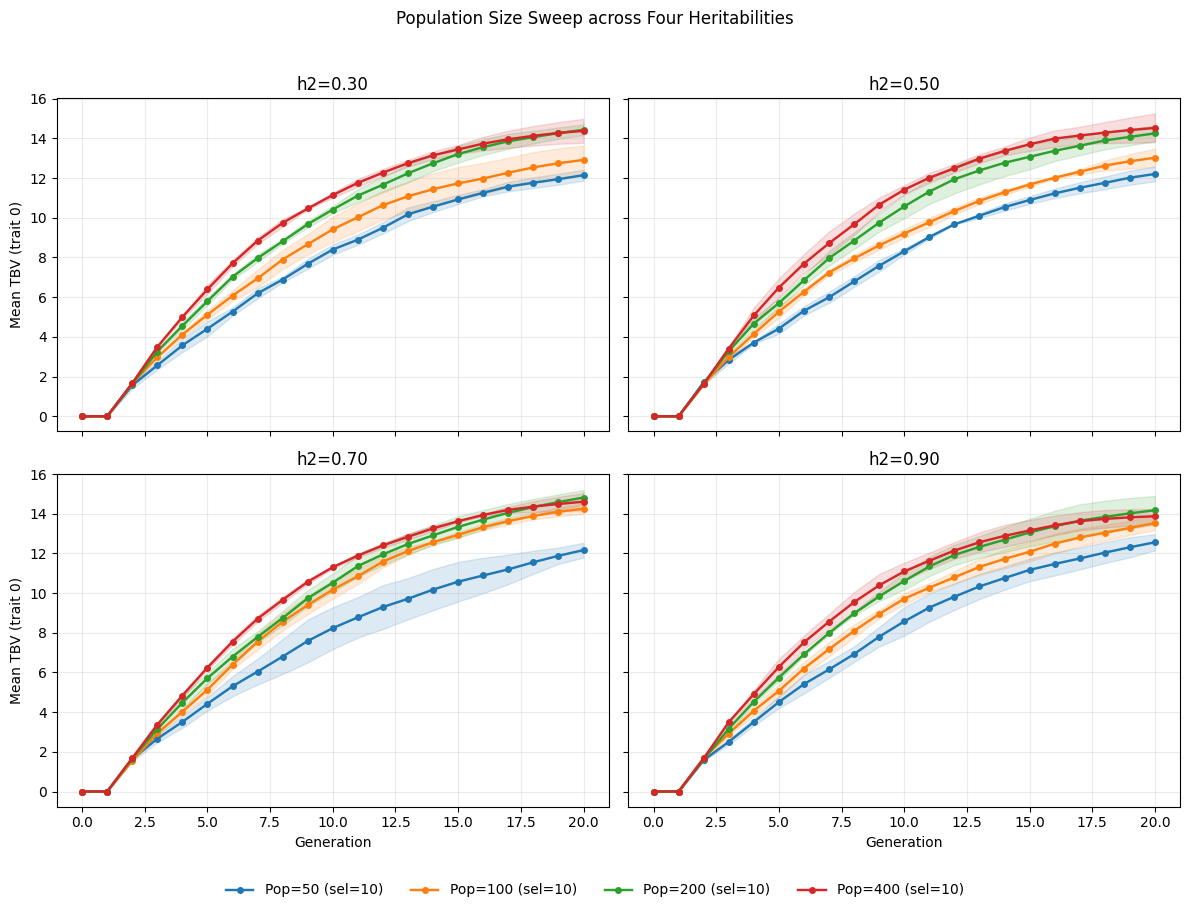

In [1]:
# experiment_h2_grid.py
# 2x2 grid of population-size sweeps across four heritabilities

from chewc.structs import *
from chewc.pheno import *
from chewc.select import *
from chewc.cross import *

import jax
import jax.numpy as jnp
from jax import lax
from functools import partial
from typing import Tuple, Dict, List

import numpy as np
import matplotlib.pyplot as plt


# ----------------------------
# Core selection step (JIT)
# ----------------------------
@partial(jax.jit, static_argnames=("n_select", "n_offspring", "max_crossovers"))
def selection_step(
    carry: BreedingState,
    _,  # Placeholder for lax.scan's iteration number
    trait: Trait,
    genetic_map: GeneticMap,
    heritabilities: jnp.ndarray,
    n_select: int,
    n_offspring: int,
    max_crossovers: int,
) -> Tuple[BreedingState, jnp.ndarray]:
    key, pheno_key, mating_key, cross_key = jax.random.split(carry.key, 4)
    current_pop = carry.population

    # 1) Phenotype & TBV
    _, tbvs = calculate_phenotypes(
        key=pheno_key, population=current_pop, trait=trait, heritability=heritabilities
    )
    mean_tbv = jnp.mean(tbvs[:, 0])  # track trait 0

    # 2) Select parents
    selected = select_top_k(current_pop, tbvs[:, 0], k=n_select)

    # 3) Random mating plan
    pairings = random_mating(mating_key, n_parents=n_select, n_crosses=n_offspring)
    mom_idx, dad_idx = pairings[:, 0], pairings[:, 1]

    # 4) Cross to make offspring
    moms_g, dads_g = selected.geno[mom_idx], selected.geno[dad_idx]
    moms_i, dads_i = selected.ibd[mom_idx], selected.ibd[dad_idx]

    vmapped_cross = jax.vmap(cross_pair, in_axes=(0, 0, 0, 0, 0, None, None))
    offspring_keys = jax.random.split(cross_key, n_offspring)
    off_g, off_i = vmapped_cross(
        offspring_keys, moms_g, dads_g, moms_i, dads_i, genetic_map, max_crossovers
    )

    # 5) Build new population/state
    new_gen = carry.generation + 1
    new_ids = jnp.arange(n_offspring, dtype=jnp.int32) + carry.next_id
    new_meta = jnp.stack(
        [
            new_ids,
            selected.meta[mom_idx, 0],
            selected.meta[dad_idx, 0],
            jnp.full((n_offspring,), new_gen, dtype=jnp.int32),
        ],
        axis=-1,
    )
    new_pop = Population(geno=off_g, ibd=off_i, meta=new_meta)

    next_state = BreedingState(
        population=new_pop, key=key, generation=new_gen, next_id=carry.next_id + n_offspring
    )
    return next_state, mean_tbv


def run_scan(
    initial_state: BreedingState,
    trait: Trait,
    genetic_map: GeneticMap,
    heritabilities: jnp.ndarray,
    n_cycles: int,
    n_select: int,
    n_offspring: int,
    max_crossovers: int,
) -> Tuple[BreedingState, jnp.ndarray]:
    """Run fixed-shape cycles with lax.scan."""
    body = lambda carry, step_idx: selection_step(
        carry,
        step_idx,
        trait=trait,
        genetic_map=genetic_map,
        heritabilities=heritabilities,
        n_select=n_select,
        n_offspring=n_offspring,
        max_crossovers=max_crossovers,
    )
    return lax.scan(body, initial_state, xs=None, length=n_cycles)


# ----------------------------
# Scenario runner (with burn-in)
# ----------------------------
def run_one_scenario(
    key: jnp.ndarray,
    founder_pop: Population,
    genetic_map: GeneticMap,
    trait: Trait,
    heritabilities: jnp.ndarray,
    *,
    n_cycles: int,
    n_select: int,
    n_offspring: int,
    max_crossovers: int,
) -> Tuple[BreedingState, jnp.ndarray]:
    """
    Returns (final_state, full_history) where full_history length = n_cycles+1 (includes Gen0).
    Burn-in step normalizes shape if founders size != n_offspring.
    """
    # Initial state
    init_state = BreedingState(
        population=founder_pop, key=key, generation=0, next_id=founder_pop.meta.shape[0]
    )

    # Gen0 TBV
    key0, ph_key0 = jax.random.split(init_state.key)
    _, tbv0 = calculate_phenotypes(
        key=ph_key0, population=init_state.population, trait=trait, heritability=heritabilities
    )
    g0 = jnp.mean(tbv0[:, 0])

    # Burn-in (respect founder size)
    n_founders = founder_pop.meta.shape[0]
    n_select_burn = int(min(n_select, n_founders))
    burn_state, g1 = selection_step(
        carry=init_state,
        _=0,
        trait=trait,
        genetic_map=genetic_map,
        heritabilities=heritabilities,
        n_select=n_select_burn,
        n_offspring=n_offspring,
        max_crossovers=max_crossovers,
    )

    # Remaining cycles with steady size
    cycles_left = max(0, n_cycles - 1)
    if cycles_left > 0:
        final_state, tbv_hist_rest = run_scan(
            burn_state,
            trait,
            genetic_map,
            heritabilities,
            n_cycles=cycles_left,
            n_select=n_select,
            n_offspring=n_offspring,
            max_crossovers=max_crossovers,
        )
        full_hist = jnp.concatenate([jnp.array([g0, g1]), tbv_hist_rest])
        return final_state, full_hist

    # Degenerate: only Gen0 + burn-in
    return burn_state, jnp.array([g0, g1])


# ----------------------------
# Population-size sweep for one h2
# ----------------------------
def compare_population_sizes(
    *,
    key: jnp.ndarray,
    founder_pop: Population,
    genetic_map: GeneticMap,
    trait_arch: Trait,
    heritabilities: jnp.ndarray,
    n_reps: int,
    n_cycles: int,
    pop_sizes: List[int],
    select_rate: float,
    max_crossovers: int,
) -> Dict[str, Dict[str, np.ndarray]]:
    """
    Returns dict[label] -> {"mean","std","all"} with trajectories of length n_cycles+1.
    """
    results = {}
    labels_in_order = []
    for N in pop_sizes:
        n_select = max(2, 10)
        # n_select = max(2, int(round(select_rate * N)))
        rep_keys = jax.random.split(key, n_reps)
        rep_hist = []
        for r in range(n_reps):
            _, full_hist = run_one_scenario(
                key=rep_keys[r],
                founder_pop=founder_pop,
                genetic_map=genetic_map,
                trait=trait_arch,
                heritabilities=heritabilities,
                n_cycles=n_cycles,
                n_select=n_select,
                n_offspring=N,
                max_crossovers=max_crossovers,
            )
            rep_hist.append(np.array(full_hist))
        all_arr = np.stack(rep_hist, axis=0)  # [n_reps, n_cycles+1]
        label = f"Pop={N} (sel={n_select})"
        labels_in_order.append(label)
        results[label] = {
            "mean": all_arr.mean(axis=0),
            "std": all_arr.std(axis=0, ddof=1) if n_reps > 1 else np.zeros_like(all_arr[0]),
            "all": all_arr,
        }
        key, _ = jax.random.split(key)  # de-correlate across N
    results["_labels_order"] = np.array(labels_in_order, dtype=object)
    return results


# ----------------------------
# Grid experiment across 4 heritabilities
# ----------------------------
def run_h2_grid_experiment(
    *,
    seed: int = 123,
    h2_list: List[float] = (0.3, 0.5, 0.7, 0.9),
    n_reps: int = 3,
    n_cycles: int = 20,
    pop_sizes: List[int] = (50, 100, 200, 400),
    select_rate: float = 0.20,
    n_founders: int = 100,
    n_chr: int = 5,
    n_loci: int = 1000,
    qtl_per_chr: int = 50,
    max_crossovers: int = 10,
):
    """
    Builds shared founders/trait once; sweeps four heritabilities; returns nested results.
    Returns: dict[h2_str] -> (results_dict_like_compare_population_sizes)
    """
    master_key = jax.random.PRNGKey(seed)
    master_key, pop_key, trait_key = jax.random.split(master_key, 3)

    # Shared founders/map/trait for comparability across h2
    founder_pop, genetic_map = quick_haplo(
        key=pop_key, n_ind=n_founders, n_chr=n_chr, seg_sites=n_loci, inbred=False, chr_length=1.0
    )
    trait_arch = add_trait(
        key=trait_key,
        founder_pop=founder_pop,
        n_qtl_per_chr=qtl_per_chr,
        mean=jnp.array([0.0]),
        var=jnp.array([1.0]),
        sigma=jnp.array([[10.0]]),
    )

    results_by_h2 = {}
    for i, h2 in enumerate(h2_list):
        master_key, use_key = jax.random.split(master_key)
        h_vec = jnp.array([float(h2)])
        res = compare_population_sizes(
            key=use_key,
            founder_pop=founder_pop,
            genetic_map=genetic_map,
            trait_arch=trait_arch,
            heritabilities=h_vec,
            n_reps=n_reps,
            n_cycles=n_cycles,
            pop_sizes=list(pop_sizes),
            select_rate=select_rate,
            max_crossovers=max_crossovers,
        )
        results_by_h2[f"h2={h2:.2f}"] = res

    return results_by_h2


# ----------------------------
# Plot: 2x2 grid (one subplot per h2)
# ----------------------------
def plot_h2_grid(results_by_h2: Dict[str, Dict[str, Dict[str, np.ndarray]]], title: str = "Population Size vs. Genetic Gain across Heritabilities"):
    # Keep label color consistent across subplots
    # Extract ordered labels from the first entry
    some_key = next(iter(results_by_h2))
    labels_order = results_by_h2[some_key]["_labels_order"]
    color_cycle = plt.rcParams["axes.prop_cycle"].by_key().get("color", ["C0","C1","C2","C3","C4"])

    # Compute a global y-range for fair visual comparison
    global_min, global_max = np.inf, -np.inf
    gens = None
    for h2_key, res in results_by_h2.items():
        for label in labels_order:
            m = res[label]["mean"]
            s = res[label]["std"]
            if gens is None:
                gens = np.arange(m.shape[0])
            global_min = min(global_min, np.min(m - s))
            global_max = max(global_max, np.max(m + s))
    # small padding
    ypad = 0.05 * (global_max - global_min + 1e-9)
    yrange = (global_min - ypad, global_max + ypad)

    # 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex=True, sharey=True)
    axes = axes.ravel()

    for ax, (h2_key, res) in zip(axes, results_by_h2.items()):
        for i, label in enumerate(labels_order):
            mean = res[label]["mean"]
            std = res[label]["std"]
            color = color_cycle[i % len(color_cycle)]
            ax.plot(gens, mean, label=label, marker="o", linewidth=1.75, markersize=4, color=color)
            ax.fill_between(gens, mean - std, mean + std, alpha=0.15, color=color)
        ax.set_title(h2_key)
        ax.grid(True, alpha=0.25)

    for ax in axes[2:]:
        ax.set_xlabel("Generation")
    for ax in axes[::2]:
        ax.set_ylabel("Mean TBV (trait 0)")

    for ax in axes:
        ax.set_ylim(*yrange)

    # Shared legend outside
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=min(len(labels), 4), frameon=False, bbox_to_anchor=(0.5, -0.02))

    fig.suptitle(title, y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


def print_summary_table_grid(results_by_h2: Dict[str, Dict[str, Dict[str, np.ndarray]]]):
    """
    Prints final TBV and total gain per (h2, population).
    """
    print("\n=== Summary by heritability (final TBV and total gain) ===")
    for h2_key, res in results_by_h2.items():
        print(f"\n-- {h2_key} --")
        rows = []
        for label in res["_labels_order"]:
            mean = res[label]["mean"]
            g0, gT = mean[0], mean[-1]
            rows.append((label, gT, gT - g0))
        rows.sort(key=lambda x: x[1], reverse=True)
        for label, gT, gain in rows:
            print(f"{label:>20s}  |  Final TBV: {gT: .4f}  |  Total Gain: {gain: .4f}")


# ----------------------------
# Run as a script
# ----------------------------
if __name__ == "__main__":
    H2_LIST = [0.30, 0.50, 0.70, 0.90]
    POP_SIZES = [50, 100, 200, 400]
    SELECT_RATE = 0.20
    N_REPS = 3
    N_CYCLES = 20

    results_by_h2 = run_h2_grid_experiment(
        seed=123,
        h2_list=H2_LIST,
        n_reps=N_REPS,
        n_cycles=N_CYCLES,
        pop_sizes=POP_SIZES,
        select_rate=SELECT_RATE,
        n_founders=100,
        n_chr=5,
        n_loci=1000,
        qtl_per_chr=50,
        max_crossovers=10,
    )

    print_summary_table_grid(results_by_h2)
    plot_h2_grid(results_by_h2, title="Population Size Sweep across Four Heritabilities")


In [6]:
#| hide
import nbdev; nbdev.nbdev_export()